In [ ]:
## Image classification

In [85]:
import pandas as pd
import xarray as xr
import tensorflow as tf
from datetime import datetime
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Cropping2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from xgboost import XGBClassifier
import xgboost as xgb
import hyperopt as hp

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/rjackson/.conda/envs/tensorflow_env/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['fmin', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
label_df = pd.read_csv('lidar_labels.csv')
label_df

,Date,Time,Label
0,2017-06-30,2011-2016,cloudy
1,2017-07-31,1745-1746,clear
2,2017-07-31,1746-0000,cloudy
3,2017-08-01,0000-0314,cloudy
4,2017-08-01,0314-0330,rain
...,...,...,...
2153,2017-09-30,2332-2334,clear
2154,2017-09-30,2334-2340,cloudy
2155,2017-09-30,2340-2342,clear
2156,2017-09-30,2342-2358,cloudy


In [14]:
date_list = np.array([datetime.datetime.strptime(x, '%Y-%m-%d').date() for x in label_df["Date"].values])
start_time_list = np.array([datetime.datetime.strptime(x[0:4], '%H%M').time() for x in label_df["Time"].values])
end_time_list = np.array([datetime.datetime.strptime(x[5:], '%H%M').time() for x in label_df["Time"].values])

def get_label(dt):
    label_ind = np.where(np.logical_and.reduce(
        (date_list == dt.date(), start_time_list <= dt.time(), end_time_list > dt.time())))
    if not label_ind[0].size:
        return np.nan
    my_string = label_df["Label"].values[label_ind][0]
        
    if my_string.lower() == 'clear':
        return 0
    elif my_string.lower() == 'cloudy' or my_string.lower() == "cloud":
        return 1
    elif my_string.lower() == 'rain':
        return 2
    
    raise ValueError("Invalid value %s for label" % my_string)
    
def dt64_to_dt(dt):
    ts = (dt - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    return datetime.datetime.utcfromtimestamp(ts)

In [ ]:
plt.plot(date_list)

In [ ]:
start_time_list = [datetime.datetime.strptime(x[0:4], '%H%M').time() for x in label_df["Time"].values]
end_time_list = [datetime.datetime.strptime(x[5:], '%H%M').time() for x in label_df["Time"].values]

In [ ]:
start_time_list

In [ ]:
get_label(datetime.datetime(2017,8,2,3,41))

In [ ]:
file_list = glob("/run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/processed_moments/sgpdlacfC1.a1.*moments.nc")

In [ ]:
my_ds = xr.open_mfdataset("/run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/processed_moments/sgpdlacfC1.a1.20170818*moments.nc")

In [ ]:
my_ds

In [ ]:
dts = np.array([dt64_to_dt(x) for x in my_ds.time.values])

In [ ]:
my_ds.snr.max().values

In [ ]:
my_ds.snr.isel(time=0).values

## Encoder for lidar data

In [4]:
tfrecords_path = '/nfs/gce/projects/digr/lidar_tfrecords/5min/*.tfrecord'
is_training = True
shuffle = False
my_shape = ()
def input_fn():
    def parse_record(record):
        feature={'width': tf.io.FixedLenFeature([], tf.int64, default_value=0),
                 'height': tf.io.FixedLenFeature([], tf.int64, default_value=0),
                 'image_raw': tf.io.FixedLenFeature([], tf.string, default_value=""),
                 'start_time': tf.io.FixedLenFeature([], tf.float32, default_value=0),
                 'end_time': tf.io.FixedLenFeature([], tf.float32, default_value=0)
                 }
        features = tf.io.parse_single_example(record, feature)
        my_shape = (features['width'], features['height'], 1)
        features['image_raw'] = tf.io.decode_raw(features['image_raw'], tf.float64)

        features['image_raw'] = tf.reshape(features['image_raw'], shape=list(my_shape))
             
        return {'input_1': features['image_raw'], 'width': features['width'], 'height': features['height'],
                'conv2d_6': features['image_raw'], 'start_time': features['start_time'],
                'end_time': features['end_time']}

    file_list = sorted(glob(tfrecords_path))
    dataset = tf.data.TFRecordDataset(file_list)

    if is_training:
        if shuffle:
            dataset = dataset.shuffle()
        else:
            dataset = dataset.repeat()

    dataset = dataset.map(parse_record)
    dataset = dataset.batch(20)
    dataset = tf.data.Dataset.zip((dataset, dataset))
    
    return dataset

def _int64_feature(value):
    """Creates a tf.Train.Feature from an int64 value."""
    if value is None:
        value = []
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def _bytes_feature(value):
    """Creates a tf.Train.Feature from a bytes value."""
    if value is None:
        value = []
    if isinstance(value, np.ndarray):
        value = value.reshape(-1)
        value = bytes(value)
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))

def _float_feature(value):
    """Creates a tf.Train.Feature from a bytes value."""
    if value is None:
        value = []
    if isinstance(value, np.ndarray):
        value = value.reshape(-1)
        value = bytes(value)
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

In [5]:
dataset = input_fn()

In [6]:
trainset = dataset.shard(2, 0)
testset = dataset.shard(2, 1)

In [7]:
x = [x for x in trainset.take(1)]

In [8]:
times = x[0][0]["start_time"]
labels = np.array([get_label(y) for y in pd.to_datetime(times.numpy())])
labels.shape

(20,)

In [8]:
inp = Input(shape=(None, None, 1))
pad_x = np.ceil(x[0][0]['width'].numpy()[0] / 8) * 8 - x[0][0]['width'].numpy()[0]
pad_y = np.ceil(x[0][0]['height'].numpy()[0] / 8) * 8 - x[0][0]['height'].numpy()[0]
x = ZeroPadding2D(((0, int(pad_x)), (0, int(pad_y))))(inp)
x = Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu')(x)

encoded = MaxPooling2D((3, 3), padding='same')(x)

x = Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Cropping2D(((0, int(pad_x)), (0, int(pad_y))))(x)
decoded = Conv2D(1, kernel_size=(3, 3), activation='relu', padding='same')(x)

In [ ]:
trainset

In [ ]:
my_shape

In [10]:
model = Model(inp, decoded)
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
checkpointer = ModelCheckpoint(filepath=('/home/rjackson/arming_the_edge/models/encoder-decoder/model-4layers-z-only-5min-{epoch:03d}.hdf5'),
            verbose=1)
early_stop = EarlyStopping(patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=2)
model.fit(trainset, epochs=100, steps_per_epoch=100, callbacks=[checkpointer, reduce_lr, early_stop],
          validation_data=testset, validation_steps=20)

Train for 100 steps, validate for 20 steps
Epoch 1/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0018
Epoch 00001: saving model to /home/rjackson/arming_the_edge/models/encoder-decoder/model-4layers-z-only-5min-001.hdf5
100/100 [==============================] - 48s 476ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 2/100
 99/100 [============================>.] - ETA: 0s - loss: 7.1189e-04
Epoch 00002: saving model to /home/rjackson/arming_the_edge/models/encoder-decoder/model-4layers-z-only-5min-002.hdf5
100/100 [==============================] - 47s 470ms/step - loss: 7.0969e-04 - val_loss: 0.0014
Epoch 3/100
 99/100 [============================>.] - ETA: 0s - loss: 2.8299e-04
Epoch 00003: saving model to /home/rjackson/arming_the_edge/models/encoder-decoder/model-4layers-z-only-5min-003.hdf5
100/100 [==============================] - 48s 482ms/step - loss: 2.8308e-04 - val_loss: 0.0014
Epoch 4/100
 99/100 [============================>.] - ETA: 0s - loss: 7.7951

In [9]:
model = load_model('/home/rjackson/arming_the_edge/models/encoder-decoder/model-z-only-5min-100.hdf5')

In [19]:
model.evaluate(testset, steps=30)

30/30 [==============================] - 6s 187ms/step - loss: 2.7719e-04


0.00027718579998084654

In [20]:
my_set = testset.take(1)
predicted_set = model.predict(my_set, steps=10)
observed_set = [x[0]['input_1'].numpy() for x in my_set][0]

In [12]:
predicted_set.shape

(20, 195, 400, 1)

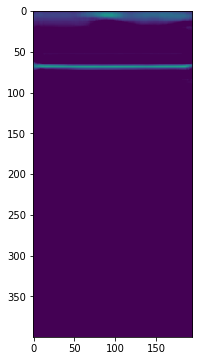

In [23]:
plt.figure(figsize=(10,6))
plt.imshow(predicted_set[19,:,:,0].T, vmin=0, vmax=1)

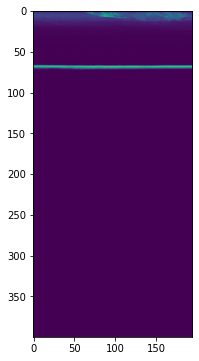

In [25]:
plt.figure(figsize=(10,6))
plt.imshow(observed_set[19,:,:,0].T, vmin=0, vmax=1)

In [53]:
predicted_set[12,:,:,0]

array([[0.18414336, 0.05784798, 0.05158192, ..., 0.04642639, 0.050753  ,
        0.12982398],
       [0.08962706, 0.0191319 , 0.01661184, ..., 0.01514262, 0.01693615,
        0.10374683],
       [0.08008274, 0.01580891, 0.01367441, ..., 0.01226014, 0.01369983,
        0.09470752],
       ...,
       [0.06935835, 0.0131906 , 0.01120579, ..., 0.00982255, 0.01086599,
        0.08800167],
       [0.06981632, 0.01332211, 0.0112935 , ..., 0.00989696, 0.01097006,
        0.08866358],
       [0.1263856 , 0.05585331, 0.05092207, ..., 0.04989919, 0.05286768,
        0.29370615]], dtype=float32)

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, None, None, 1)     0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 16)    160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 16)    0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 8)     1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 8)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 8)     584   

In [10]:
encoder_model = Model(inp, encoded)
encoder_model.load_weights('/home/rjackson/arming_the_edge/models/encoder-decoder/model-z-only-5min-100.hdf5',
                           by_name=True)   
encoder_model.compile(optimizer='adam', loss='mean_squared_error')
encoder_model.save('encoder.hdf')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: encoder.hdf/assets


In [206]:
encoder_model.layers[0]

In [11]:
encoder_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, None, None, 1)     0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 16)    160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 16)    0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 8)     1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 8)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 8)     584   

In [12]:
num_batches = 150
testset_batch = testset.take(150)
trainset_batch = trainset.take(150)
test_arrays = [x[0]["input_1"].numpy() for x in testset_batch]
train_arrays = [x[0]["input_1"].numpy() for x in trainset_batch]
test_times = np.stack([pd.to_datetime(x[0]["start_time"].numpy()) for x in testset_batch])
train_times = np.stack([pd.to_datetime(x[0]["start_time"].numpy()) for x in trainset_batch])

In [33]:
test_labels = np.array([get_label(dt64_to_dt(x)) for x in test_times.flatten()])
train_labels = np.array([get_label(dt64_to_dt(x)) for x in train_times.flatten()])

/home/rjackson/.conda/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


In [32]:
test_labels.shape

(3000,)

In [39]:
encoded_data_test = [encoder_model.predict(x) for x in test_arrays]
encoded_data_train = [encoder_model.predict(x) for x in train_arrays]
my_shp = encoded_data_train[0].shape

In [40]:
encoded_data_test = np.stack([x.reshape((my_shp[0], np.prod(my_shp[1:]))) for x in encoded_data_test])
encoded_data_train = np.stack([x.reshape((my_shp[0], np.prod(my_shp[1:]))) for x in encoded_data_train])
my_new_shape = encoded_data_test.shape
encoded_data_test = encoded_data_test.reshape((my_new_shape[0]*my_new_shape[1], my_new_shape[2]))
encoded_data_train = encoded_data_train.reshape((my_new_shape[0]*my_new_shape[1], my_new_shape[2]))

In [41]:
encoded_data_train.shape

(3000, 4624)

## Train GBM with with hyperparameter optimization

In [132]:
from hyperopt import hp, tpe, fmin, Trials, rand
my_space = {'max_depth': hp.randint('max_depth', 10),
            'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
            'n_estimators': hp.uniform('n_estimators', 50, 200)}

my_classifier = XGBClassifier(n_jobs=8)
N_FOLDS = 10
def objective(params, n_folds = N_FOLDS):
    """Objective function for Gradient Boosting Machine Hyperparameter Tuning"""
    train_set = xgb.DMatrix(encoded_data_train, label=train_labels)
    # Perform n_fold cross validation with hyperparameters
    # Use early stopping and evalute based on ROC AUC
    cv_results = xgb.cv(params, train_set, nfold = n_folds, num_boost_round = 10000, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 50)
   
    print(cv_results)
    # Extract the best score
    best_score = max(cv_results['test-auc-mean'])
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [129]:
bayes_trials = Trials()

In [ ]:
MAX_EVALS = 50

# Optimize
best = fmin(fn = objective, space = my_space, algo = rand.suggest, 
            max_evals = MAX_EVALS)

  0%|          | 0/50 [00:00<?, ?it/s, best loss: ?]

In [61]:
where_nan = np.isnan(train_labels)
encoded_data_train = encoded_data_train[~where_nan, :]
train_labels = train_labels[~where_nan]
where_nan_test = np.isnan(test_labels)
encoded_data_test = encoded_data_test[~where_nan_test, :]
test_labels = test_labels[~where_nan_test]

In [62]:
encoded_data_train.shape

(2816, 4624)

In [122]:
my_classifier.fit(encoded_data_train, train_labels, verbose=True)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=8,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [123]:
labels_predict_test = my_classifier.predict(encoded_data_test)
labels_predict_train = my_classifier.predict(encoded_data_train)

In [124]:
num_correct = len(np.where(test_labels - labels_predict_test == 0)[0])
total = len(test_labels)
print("Percent correct in testing set: %3.2f" % (num_correct/total * 100))
num_correct = len(np.where(train_labels - labels_predict_train == 0)[0])
total = len(train_labels)
print("Percent correct in training set: %3.2f" % (num_correct/total * 100))

Percent correct in testing set: 86.66
Percent correct in training set: 97.09
